## 1 Softmax回归的理论模型

### 1.1 模型定义
本章节中，如无特别说明，向量均指列向量。

softmax回归是logistic回归（适用于2类分类）扩展到多类分类的结果。设标签$c \in \{1, ..., C \}$，对于样本$(\vec{x}, y)$，
softmax回归预测样本标签为$c$的概率为
$$
p(y=c|\vec{x}) = softmax(\vec{w}_c^\top \vec{x}) = \frac{\exp (\vec{w}_c^\top \vec{x})}{\sum_{c'=1}^C \exp (\vec{w}_{c'}^\top \vec{x})},
$$
因此softmax回归的预测结果为
$$
\hat{y} = argmax_{c=1}^C p(y=c|\vec{x}) = argmax_{c=1}^C \vec{w}_c^\top \vec{x}.
$$
本质上，softmax回归是一个单层神经网络，输出层为softmax层。

### 1.2 单样本的矢量计算表达式
为了更方便地定义torch tensor，假设所有向量均为**行向量**。

设$d$为样本特征个数且$\vec{x} \in \mathbb{R}^{1 \times d}$，$W \in \mathbb{R}^{d \times C}$为待学习的权重，$\vec{b} \in \mathbb{R}^{1 \times C}$为偏置，则对于样本$(\vec{x}^{(i)}, y^{(i)})$，softmax回归的矢量计算表达式为
$$
\hat{\vec{y}}^{(i)} = softmax (\vec{x}^{(i)} W + \vec{b}),
$$
其中$\hat{\vec{y}}^{(i)} \in \mathbb{R}^{C}$的各个元素反应了softmax回归预测各标签的概率。

### 1.3 多样本的矢量计算表达式

为了更方便地定义torch tensor，假设所有向量均为行向量。

令$X \in \mathbb{R}^{n \times d}$是$n$个样本的特征矩阵，则
$$
\hat{Y} = softmax (XW+b).
$$
PyTorch会自动开启广播模式。

### 1.4 参数学习
采用交叉熵损失函数，只关心正确类别的预测概率：
$$
l (W, \vec{b}) = - \frac{1}{N} \sum_{n=1}^N \sum_{c=1}^C y_c^{(n)} \log \hat{y}_c^{(n)}.
$$
其梯度的求导过程并不难，虽然略复杂。最终参数的更新公式为
$$
W_{t+1} \leftarrow W_t + \alpha \bigg( \frac{1}{|\mathcal{B}|} \sum_{n \in \mathcal{B}} \vec{x}^{(n)} \Big(\vec{y}^{(n)} - \hat{\vec{y}}^{(n)}_{W_t}\Big)^\top \bigg)
$$
$$
b_{t+1} \leftarrow b_t + \alpha \bigg( \frac{1}{|\mathcal{B}|} \sum_{n \in \mathcal{B}} \Big(\vec{y}^{(n)} - \hat{\vec{y}}^{(n)}_{b_t}\Big) \bigg)
$$
其中$\vec{y}^{(n)}$是一个one-hot向量，仅有true label位置对应的元素为1。

## 2 Softmax回归：从零开始实现

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
print(torch.__version__, torchvision.__version__)

import my_utils

1.3.1 0.4.2


### 2.1 获取并读取fashion-MNIST数据

In [13]:
batch_size = 256
train_iter, test_iter = my_utils.load_fashion_mnist(batch_size)

### 2.2 初始化模型参数
softmax回归是一个单层神经网络。使用fashion-MNIST数据集的时候，输入为长度是$28 \times 28 = 784$的向量，输出是$10$个label的softmax。因此权重$W \in \mathbb{R}^{d \times C} = \mathbb{R}^{784 \times 10}$，偏置$\vec{b} \in \mathbb{R}^{1 \times C} = \mathbb{R}^{1 \times 10}$。

In [14]:
num_inputs = 784
num_outputs = 10
W = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_outputs)), dtype=torch.float, requires_grad=True)
b = torch.zeros(num_outputs, dtype=torch.float, requires_grad=True)

### 2.3 实现softmax函数

In [15]:
def softmax(X):
    """
    X每行为一个样本，每列为一个类别。
    """
    X_exp = X.exp()     # 对tensor每个元素执行对数运算
    partition = X_exp.sum(dim=1, keepdim=True)    # 按照行相加（每个样本自己各label上的输出相加）
    return X_exp / partition     # N \times C / N \times 1，分母自动广播为C列

测试softmax是否将输入按行映射为一个分布：

In [16]:
X = torch.rand((2, 5))
X_prob = softmax(X)
print(X_prob, X_prob.sum(dim=1))

tensor([[0.2522, 0.2798, 0.1811, 0.1533, 0.1335],
        [0.2482, 0.2006, 0.1642, 0.1533, 0.2336]]) tensor([1.0000, 1.0000])


### 2.4 定义softmax回归模型
注意数据集的feature为``torch.Size([n, 1, 28, 28])``，要转化为``torch.Size([n, 784])``。

In [17]:
def net(X):
    return softmax(torch.mm(X.view((-1, num_inputs)), W) + b)

### 2.5 定义交叉熵损失函数
使用``gather``函数得到样本**真实标签对应的位置**的预测概率。在下面这个例子中，一个有三个样本，三个labels，``y_hat``是各样本在各label上的预测概率，y为各样本的真实label的编号。

In [18]:
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5], [0.2, 0.2, 0.6]])
y = torch.LongTensor([0, 2, 2])
y_hat.gather(1, y.view(-1, 1))

tensor([[0.1000],
        [0.5000],
        [0.6000]])

因为
$$
l (W, \vec{b}) = - \frac{1}{N} \sum_{n=1}^N \sum_{c=1}^C y_c^{(n)} \log \hat{y}_c^{(n)} = - \frac{1}{N} \sum_{n=1}^N \log \hat{y}_{true}^{(n)},
$$
所以corss_entroy返回$N$个$-\log \hat{y}_{true}^{(n)}$即可（后面会再调用``.sum()``）：

In [19]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat.gather(1, y.view(-1, 1)))

### 2.6 定义预测准确率函数

In [20]:
def accuracy(y_hat, y):
    # 将y_hat每一行最大的和y一一对应比较，返回的bool值要转换为float型变量
    return (y_hat.argmax(dim=1) == y).float().mean().item()

测试刚才的用例：

In [21]:
print('%f%%' % (accuracy(y_hat, y) * 100))

66.666669%


通过mini-batch计算全体数据上的正确率：

In [22]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0., 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

测试未经训练的模型在test_iter上的正确率（应近似label个数的倒数）：

In [23]:
print(evaluate_accuracy(test_iter, net))

0.1119


### 2.7 训练模型

In [24]:
num_epochs, lr = 5, 0.1

def general_train(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, optimizer=None):
    """
    本方法对大多数模型适用，因此写成通用的形式。
    本函数中同时实现了“从零开始实现”以及“借助torch”实现的训练代码。
    """
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0., 0., 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            # 梯度清零（针对从零实现和PyTorch实现分别给出代码）
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            # 计算梯度并根据MGD更新参数（针对从零实现和PyTorch实现分别给出代码）
            l.backward()
            if optimizer is None:
                my_utils.mgd(params, lr, batch_size)
            else:
                optimizer.step()
            
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).float().sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

general_train(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, params=[W, b], lr=lr)

epoch 1, loss 0.7856, train acc 0.749, test acc 0.793
epoch 2, loss 0.5701, train acc 0.813, test acc 0.812
epoch 3, loss 0.5263, train acc 0.825, test acc 0.816
epoch 4, loss 0.5009, train acc 0.833, test acc 0.825
epoch 5, loss 0.4854, train acc 0.836, test acc 0.829


### 2.8 预测

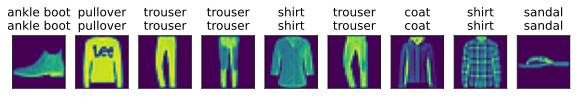

In [17]:
X, y = iter(test_iter).next()

true_labels = my_utils.get_fashion_mnist_labels(y.numpy())
pred_labels = my_utils.get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]
my_utils.show_fashion_mnist(X[0:9], titles[0:9])

## 3 Softmax回归：PyTorch实现

In [25]:
from torch import nn
from torch.nn import init
import numpy as np

### 3.1 获取并读取fashion-MNIST数据

In [26]:
batch_size = 256
train_iter, test_iter = my_utils.load_fashion_mnist(batch_size)

### 3.2 定义并初始化模型

In [27]:
num_inputs = 784
num_outputs = 10

class LinearNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
    def forward(self, x):
        # (batch, 1, 28, 28) --> (batch, 784)
        y = self.linear(x.view(x.shape[0], -1))
        return y

net = LinearNet(num_inputs, num_outputs)
print(net)
print(net.linear)

LinearNet(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)
Linear(in_features=784, out_features=10, bias=True)


使用Sequential或者Module来定义：

In [28]:
from collections import OrderedDict

class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x):
        return x.view(x.shape[0], -1)

net = nn.Sequential(
#     FlattenLayer(), 
#     nn.Linear(num_inputs, num_outputs)
    OrderedDict([
        ('flatten', FlattenLayer()), 
        ('linear', nn.Linear(num_inputs, num_outputs))
    ])
)
print(net)
print(net.flatten, net.linear)

Sequential(
  (flatten): FlattenLayer()
  (linear): Linear(in_features=784, out_features=10, bias=True)
)
FlattenLayer() Linear(in_features=784, out_features=10, bias=True)


查看所有可学习参数：

In [29]:
for param in net.parameters():
    print(param)   # net.flatten没有参数

Parameter containing:
tensor([[-0.0186, -0.0168,  0.0317,  ..., -0.0124, -0.0309, -0.0351],
        [-0.0075,  0.0019,  0.0130,  ...,  0.0246, -0.0169, -0.0220],
        [-0.0327, -0.0125, -0.0304,  ..., -0.0227, -0.0245, -0.0005],
        ...,
        [-0.0232, -0.0293,  0.0201,  ..., -0.0164, -0.0297,  0.0327],
        [ 0.0145, -0.0246, -0.0351,  ..., -0.0196,  0.0239,  0.0026],
        [ 0.0265, -0.0335, -0.0199,  ..., -0.0102, -0.0270, -0.0037]],
       requires_grad=True)
Parameter containing:
tensor([-0.0153, -0.0208,  0.0289, -0.0265,  0.0196, -0.0127, -0.0275,  0.0092,
         0.0329,  0.0154], requires_grad=True)


In [30]:
init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

### 3.3 确定损失函数和优化算法

In [31]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

### 3.4 训练模型

In [32]:
general_train(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0031, train acc 0.748, test acc 0.776
epoch 2, loss 0.0022, train acc 0.812, test acc 0.788
epoch 3, loss 0.0021, train acc 0.827, test acc 0.813
epoch 4, loss 0.0020, train acc 0.832, test acc 0.816
epoch 5, loss 0.0019, train acc 0.837, test acc 0.825


### 3.5 预测

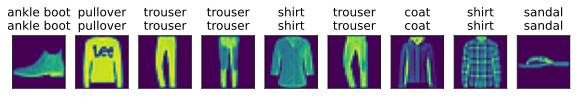

In [33]:
X, y = iter(test_iter).next()

true_labels = my_utils.get_fashion_mnist_labels(y.numpy())
pred_labels = my_utils.get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]
my_utils.show_fashion_mnist(X[0:9], titles[0:9])